In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
from datetime import datetime as dt
import time
import re
from functools import partial

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

DRIVE_PATH = "/content/gdrive/My Drive/Colab Notebooks/"
TRAIN_FILE = "datasets/train.csv"
CORRECTED_TRAIN_FILE = "datasets/corrected_train.csv"
TEST_FILE = "datasets/test.csv"
GLOVE_FILE = "embeddings/glove.840B.300d/glove.840B.300d.txt"

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Toolbox

In [0]:
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

def load_data(path = DRIVE_PATH, file = CORRECTED_TRAIN_FILE):
    csv_path = os.path.join(path,file)
    return pd.read_csv(csv_path)

def tokenize(sentences_list):
    return [re.findall(r"[\w]+|[']|[.,!?;]", str(x)) for x in sentences_list] 
    
def get_vocab(sentences):
    vocab={}
    for sentence in sentences:
        for word in sentence:
            try:
                vocab[word] +=1
            except KeyError:
                vocab[word] = 1
    return vocab

def glove_embeddings(vocabulary_in_set, drive = DRIVE_PATH, gloveFile = GLOVE_FILE ,extract = -1):

    glove_file = os.path.join(drive,gloveFile)
  
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')

    embeddings = []
    words_id = {}
    f = open(glove_file,'r', encoding="utf8")
    increment = 0
    words_id[""]=0
    first = True
    i = 1
    
    for line in f:
        word, vect = get_coefs(*line.split(" "))
        if first:
            embeddings.append(np.zeros_like(vect))
            first = False
        if word in vocabulary_in_set:
            embeddings.append(vect)
            words_id[word] = i
            i += 1
            if increment == extract - 1:
                break
            elif extract != -1:
                increment += 1
    f.close()   
    return np.array(embeddings), words_id

def df_to_data_target(df, data_col = "corrected_question_text", target_col = "target"):
    data = df[data_col]
    target = df[target_col]
    return np.c_[data, target]

def embed_and_pad(X, embeddings, n_dims, width):
    padded_X = np.zeros((len(X),width,n_dims))
    i = 0
    for sentence in X:
        j = 0
        for word in sentence:
            padded_X[i,j,:] = embeddings[word]
            j += 1
        i +=1
    return padded_X

def numpy_ewma_vectorized(data, alpha):
    alpha_ = 1-alpha
    D = pd.DataFrame(data)
    M = D.ewm(alpha=alpha_).mean()
    out = M.values
    return out

In [0]:
class data_split_and_batch:
    def __init__(self, data_targets, dv=0, cv=0, batch_size=500, words_ids = None, seed=42):
        self.seed = seed
        np.random.seed(seed)
        self.batch_length = batch_size
        self.pointer = 0
        self.reshuffle_seed = 0
        self.__split__(data_targets=data_targets, dv=dv, cv=cv, words_ids=words_ids)
    
    def __split__(self, data_targets, dv, cv, words_ids):
        positive_data_targets = data_targets[data_targets[:,1]==1]
        negative_data_targets = data_targets[data_targets[:,1]==0]
        
        positive_length = len(positive_data_targets)
        negative_length = len(negative_data_targets)
  
        pos_data_targets = positive_data_targets[np.random.permutation(positive_length), :]
        neg_data_targets = negative_data_targets[np.random.permutation(negative_length), :]
        
        if dv != 0:
            dv_positive = int(dv * positive_length/(positive_length + negative_length))
            dv_negative = dv - dv_positive
            dv_data_targets = np.concatenate((positive_data_targets[0:dv_positive,:], negative_data_targets[0:dv_negative,:]))
            dv_data_targets = dv_data_targets[np.random.permutation(dv), :]
            self.dv_targets = dv_data_targets[:,1].astype(float)
            X_dev = self.__tokenize__(dv_data_targets[:,0])
            self.X_dv_lengths = np.array(list(map(len, X_dev)))
            if words_ids == None:
                self.dv_data = X_dev
            else:
                self.dv_data = self.__ids_and_pad__(X_dev,words_ids[0], words_ids[1])
        else:
            dv_positive = 0
            dv_negative = 0
            
        if cv != 0:
            cv_positive = int(cv * positive_length/(positive_length + negative_length))
            cv_negative = cv - cv_positive
            cv_data_targets = np.concatenate((positive_data_targets[dv_positive:dv_positive + cv_positive,:], negative_data_targets[dv_negative:dv_negative + cv_negative,:]))
            cv_data_targets = cv_data_targets[np.random.permutation(cv), :]
            self.cv_targets = cv_data_targets[:,1].astype(float)
            X_cross = self.__tokenize__(cv_data_targets[:,0])
            self.X_cv_lengths = np.array(list(map(len, X_cross)))
            if words_ids == None:
                self.cv_data = X_cross
            else:
                self.cv_data = self.__ids_and_pad__(X_cross,words_ids[0], words_ids[1])   
        else:
            cv_positive = 0
            cv_negative = 0
            
        train_data_targets = np.concatenate((positive_data_targets[dv_positive + cv_positive:,:], negative_data_targets[dv_negative + cv_negative:,:]))
        train_data_targets = train_data_targets[np.random.permutation(len(data_targets)-dv-cv), :]
        self.train_targets = train_data_targets[:,1].astype(float)
        X_train = self.__tokenize__(train_data_targets[:,0])
        self.X_train_lengths = np.array(list(map(len, X_train)))
        if words_ids == None:
            self.train_data = X_train
        else:
            self.train_data = self.__ids_and_pad__(X_train ,words_ids[0], words_ids[1])
        self.num_train_examples = len(self.train_targets)
        self.nr_batches = self.num_train_examples//self.batch_length
    
    def __tokenize__(self, X):
        return [re.findall(r"[\w]+|[']|[.,!?;]", str(x)) for x in X]
    
    def __ids_and_pad__(self, X, word_ids, width):
        padded_X = np.zeros((len(X),width))
        i = 0
        for sentence in X:
            j = 0
            for word in sentence:
                padded_X[i,j] = word_ids[word]
                j += 1
            i +=1
        return padded_X
    
    def cross_val_set(self):
        return self.X_cv_lengths, self.cv_data, self.cv_targets 
    
    def dev_set(self):
        return self.X_dv_lengths, self.dv_data, self.dv_targets
    
    def next_batch(self):
        self.pointer += 1
        X_batch = self.train_data[(self.pointer - 1)*self.batch_length:self.pointer*self.batch_length]
        y_batch = self.train_targets[(self.pointer - 1)*self.batch_length:self.pointer*self.batch_length]
        X_batch_lengths = self.X_train_lengths[(self.pointer - 1)*self.batch_length:self.pointer*self.batch_length]
        
        if self.pointer == self.nr_batches:
            self.pointer = 0
            self.reshuffle_seed += 1
            np.random.seed(self.seed + self.reshuffle_seed)
            permutations = np.random.permutation(self.num_train_examples)
            self.train_data = self.train_data[permutations]
            self.train_targets = self.train_targets[permutations]
            self.X_train_lengths = self.X_train_lengths[permutations]
            
        return X_batch_lengths, X_batch, y_batch
    
    def reset(self):
        self.pointer = 0        

# Load and prepare data

In [6]:
train_data = load_data()
train_data.head()

,qid,target,corrected_question_text
0,00002165364db923c7e6,0,How did Quebec nationalists see their province...
1,000032939017120e6e44,0,"Do you have an adopted dog , how would you enc..."
2,0000412ca6e4628ce2cf,0,Why does velocity affect time ? Does velocity ...
3,000042bf85aa498cd78e,0,How did Otto von Guericke used the Magdeburg h...
4,0000455dfa3e01eae3af,0,Can I convert montra helicon D to a mountain b...


In [0]:
data_targets = df_to_data_target(train_data)

In [0]:
tokenized_questions = tokenize(train_data["corrected_question_text"].values)
vocabulary_in_set = get_vocab(tokenized_questions)

In [0]:
embeddings, words_ids = glove_embeddings(vocabulary_in_set=vocabulary_in_set)

# Construction phase

In [0]:
reset_graph()

n_steps = 250
window_width = [3, 4, 5]
out_channels = [n_steps-window_width[0]+1, n_steps-window_width[1]+1, n_steps-window_width[2]+1]
embedding_dimensions = 300
n_fc1 = 300
n_fc2 = 300
n_fc3 = 300
n_fc4 = 200
n_fc5 = 100
n_output = 1
threshold = 1.
lambda_ = 0.05

activation_fn = tf.nn.elu
he_init = tf.variance_scaling_initializer()

init_W_CL_3 = np.random.randn(window_width[0],embedding_dimensions,1,out_channels[0]).astype(np.float32)
init_b_CL_3 = np.random.randn(1,1,1,out_channels[0]).astype(np.float32)
init_W_CL_4 = np.random.randn(window_width[1],embedding_dimensions,1,out_channels[1]).astype(np.float32)
init_b_CL_4 = np.random.randn(1,1,1,out_channels[1]).astype(np.float32)
init_W_CL_5 = np.random.randn(window_width[2],embedding_dimensions,1,out_channels[2]).astype(np.float32)
init_b_CL_5 = np.random.randn(1,1,1,out_channels[2]).astype(np.float32)


X = tf.placeholder(tf.int32, [None, n_steps], name="X") #m * n_steps
y = tf.placeholder(tf.float32, [None], name="y")
learning_rate = tf.placeholder(tf.float32)
#training = tf.placeholder_with_default(False, shape=(), name='training')

with tf.name_scope("embedding_layer"):
    word_embeddings = tf.Variable(initial_value=embeddings, trainable=False)# n_words * embedding_dimensions
    embedded_sentences = tf.nn.embedding_lookup(word_embeddings, X) # m * n_steps * embedding_dimensions

with tf.name_scope("CNN_3"):
    W_CL_3 = tf.Variable(initial_value=init_W_CL_3)
    b_CL_3 = tf.Variable(initial_value=init_b_CL_3)
    CL_3 = tf.nn.conv2d(tf.reshape(embedded_sentences,[-1,n_steps,embedding_dimensions,1]), W_CL_3, strides=[1,1,1,1], padding="VALID")# m * n_steps - 3 + 1 *1 * out_channels 
    activated_CL_3 = activation_fn(tf.add(CL_3,b_CL_3)) # m * n_steps - 5 + 1 * 1 * out_channels
    MAXPOOL_3 = tf.reshape(tf.math.reduce_max(activated_CL_3,axis=1),[-1,out_channels[0]]) # m * 1 * out_channels  --> m * out_channels
    
with tf.name_scope("CNN_4"):
    W_CL_4 = tf.Variable(initial_value=init_W_CL_4)
    b_CL_4 = tf.Variable(initial_value=init_b_CL_4)
    CL_4 = tf.nn.conv2d(tf.reshape(embedded_sentences,[-1,n_steps,embedding_dimensions,1]), W_CL_4, strides=[1,1,1,1], padding="VALID")# m * n_steps - 4 + 1 *1 * out_channels 
    activated_CL_4 = activation_fn(tf.add(CL_4,b_CL_4)) # m * n_steps - 5 + 1 * 1 * out_channels
    MAXPOOL_4 = tf.reshape(tf.math.reduce_max(activated_CL_4,axis=1),[-1,out_channels[1]]) # m * 1 * out_channels  --> m * out_channels
    
with tf.name_scope("CNN_5"):
    W_CL_5 = tf.Variable(initial_value=init_W_CL_5)
    b_CL_5 = tf.Variable(initial_value=init_b_CL_5)
    CL_5 = tf.nn.conv2d(tf.reshape(embedded_sentences,[-1,n_steps,embedding_dimensions,1]), W_CL_5, strides=[1,1,1,1], padding="VALID")# m * n_steps - 5 + 1 *1 * out_channels 
    activated_CL_5 = activation_fn(tf.add(CL_5,b_CL_5)) # m * n_steps - 5 + 1 * 1 * out_channels
    MAXPOOL_5 = tf.reshape(tf.math.reduce_max(activated_CL_5,axis=1),[-1,out_channels[2]]) # m * 1 * out_channels  --> m * out_channels

with tf.name_scope("Max_pool"):
    MAXPOOL = tf.concat([MAXPOOL_3,MAXPOOL_4,MAXPOOL_5], axis=1)
    
with tf.name_scope("fully_connected_layers"):
    fc_layer = partial(tf.layers.dense, activation=activation_fn, kernel_regularizer=tf.contrib.layers.l2_regularizer(lambda_), kernel_initializer=he_init)
    fc1 = fc_layer(MAXPOOL, n_fc1)
    fc2 = fc_layer(fc1, n_fc2)
    fc3 = fc_layer(fc2, n_fc3)
    fc4 = fc_layer(fc3, n_fc4)
    fc5 = fc_layer(fc4, n_fc5)


with tf.name_scope("logits_and_outputs"):
    logits = tf.reshape(tf.contrib.layers.fully_connected(fc5, n_output, activation_fn=None),shape=[-1])
    outputs = tf.sigmoid(logits)
    predictions = tf.round(outputs)

with tf.name_scope("loss"):
    xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)
    base_loss = tf.reduce_mean(xentropy)
    reg_loss = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    loss = tf.add_n([base_loss] + reg_loss)

with tf.name_scope("evaluation"):
    TP = tf.count_nonzero(predictions * y)
    TN = tf.count_nonzero((predictions - 1) * (y - 1))
    FP = tf.count_nonzero(predictions * (y - 1))
    FN = tf.count_nonzero((predictions - 1) * y)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    accuracy = (TP + TN)/(TP + FP + TN + FN)
    f1 = 2 * precision * recall / (precision + recall)

with tf.name_scope("training_op"):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    grads_and_vars = optimizer.compute_gradients(loss)
    capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var) for grad, var in grads_and_vars]
    l2_grads = tf.norm(grads_and_vars[0])
    l2_capped_grads = tf.norm(capped_gvs[0])
    training_op = optimizer.apply_gradients(capped_gvs)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

f1_train_summary = tf.summary.scalar('Train_F1_score', f1)
f1_dev_summary = tf.summary.scalar("Dev_F1_score", f1)
loss_train_summary = tf.summary.scalar("Train_loss", loss)
loss_dev_summary = tf.summary.scalar("Dev_loss", loss)

# Training phase

In [0]:
batch_size = 50

QIQC = data_split_and_batch(data_targets, cv=1000, dv=2000, batch_size=batch_size, words_ids=(words_ids,n_steps))
X_dev_lengths, X_dev_set, y_dev_set = QIQC.dev_set()

In [12]:
"""lengths, x_b, y_b = QIQC.next_batch()
item = x_b[26]
sentence = []
for i in range(lengths[26]):
  for word, key in words_ids.items():
    if item[i] == key:
      sentence.append(word)
sentence, y_b[26]"""

'lengths, x_b, y_b = QIQC.next_batch()\nitem = x_b[26]\nsentence = []\nfor i in range(lengths[26]):\n  for word, key in words_ids.items():\n    if item[i] == key:\n      sentence.append(word)\nsentence, y_b[26]'

In [0]:
model_version = "4.2"

In [14]:
QIQC.reset()
n_epoch = 8
MODELS_FILE = "models/model{}/QIQC_model{}.ckpt".format(model_version,model_version)
modfil = os.path.join(DRIVE_PATH,MODELS_FILE)


t_init = time.time()
lr_stop = 1
lr_stack = []
loss_stack = []
step_stack = []
f1_stack = []
loss_train_stack = []
f1_train_stack = []
grads_train_stack = []
capped_grads_train_stack = []

lr = 0.004

with tf.Session() as sess:
    init.run()
    t_0 = time.time()
    for epoch in range(n_epoch):
        if epoch % 2 == 0 and epoch != 0 :
          lr = lr/2
        for iteration in range(QIQC.nr_batches):            
            X_lengths, X_batch, y_batch = QIQC.next_batch()
            _,grads, capped_grads, f1_train, loss_train = sess.run([training_op, l2_grads, l2_capped_grads, f1, loss], feed_dict={X: X_batch, y: y_batch, learning_rate: lr})
            step = epoch * QIQC.nr_batches + iteration
            if step % 200 ==0:
              f1_dev, loss_dev = sess.run([f1, loss], feed_dict = {X : X_dev_set, y : y_dev_set})
              step_stack.append(step)
              loss_stack.append(loss_dev)
              f1_stack.append(f1_dev)
              loss_train_stack.append(loss_train)
              f1_train_stack.append(f1_train)
              grads_train_stack.append(grads)
              capped_grads_train_stack.append(capped_grads)

            if iteration % 10000 == 0:
                save_path = saver.save(sess,modfil)
            if iteration % 1000 == 0:
                #f1_train, loss_train = sess.run([f1, loss],feed_dict = {X : X_batch, y : y_batch})
                #f1_dev, loss_dev = sess.run([f1, loss], feed_dict = {X : X_dev_set, y : y_dev_set})
                t_1 = time.time()
                t_delta = t_1 - t_0
                expected_runtime = t_delta * ((n_epoch - epoch - 1) * QIQC.nr_batches + (QIQC.nr_batches - iteration))/1000
                expected_runtime_h = int(expected_runtime//3600)
                expected_runtime_min = int((expected_runtime - 3600 * expected_runtime_h)//60)
                expected_runtime_sec = int((expected_runtime - 3600 * expected_runtime_h - 60 * expected_runtime_min))
                t_0 = t_1
                print("Ep. {}/{}; It. {}/{}; Runtime {:.2f} s; Remaining runtime {}h{}min{}s; f1_train {:.4f}; f1_dev {:.4f}; loss_train {:.4f}; loss_dev {:.4f}".format(epoch + 1, n_epoch, iteration, QIQC.nr_batches, t_delta, expected_runtime_h,expected_runtime_min,expected_runtime_sec,f1_train,f1_dev,loss_train,loss_dev))
    save_path = saver.save(sess,modfil)
t_final = time.time()
actual_runtime_h = int((t_final - t_init)//3600)
actual_runtime_min = int((t_final - t_init - 3600 * actual_runtime_h)//60)
actual_runtime_sec = int((t_final - t_init - 3600 * actual_runtime_h - 60 * actual_runtime_min))

print("Total actual runtime: {} hours {} min {} sec".format(actual_runtime_h, actual_runtime_min, actual_runtime_sec))

Ep. 1/8; It. 0/26062; Runtime 11.01 s; Remaining runtime 0h38min15s; f1_train 0.1176; f1_dev nan; loss_train 30.6862; loss_dev 41.9695
Ep. 1/8; It. 1000/26062; Runtime 41.96 s; Remaining runtime 2h25min7s; f1_train nan; f1_dev 0.5059; loss_train 0.3052; loss_dev 0.3009
Ep. 1/8; It. 2000/26062; Runtime 41.88 s; Remaining runtime 2h24min7s; f1_train 0.4000; f1_dev 0.1176; loss_train 0.1605; loss_dev 0.1779
Ep. 1/8; It. 3000/26062; Runtime 41.95 s; Remaining runtime 2h23min40s; f1_train nan; f1_dev 0.2083; loss_train 0.1441; loss_dev 0.1810
Ep. 1/8; It. 4000/26062; Runtime 41.95 s; Remaining runtime 2h22min59s; f1_train 0.6667; f1_dev 0.4046; loss_train 0.1923; loss_dev 0.1626
Ep. 1/8; It. 5000/26062; Runtime 41.92 s; Remaining runtime 2h22min9s; f1_train 0.6667; f1_dev 0.3057; loss_train 0.0922; loss_dev 0.1610
Ep. 1/8; It. 6000/26062; Runtime 41.93 s; Remaining runtime 2h21min30s; f1_train 0.5714; f1_dev 0.5746; loss_train 0.2384; loss_dev 0.1920
Ep. 1/8; It. 7000/26062; Runtime 41.99 s

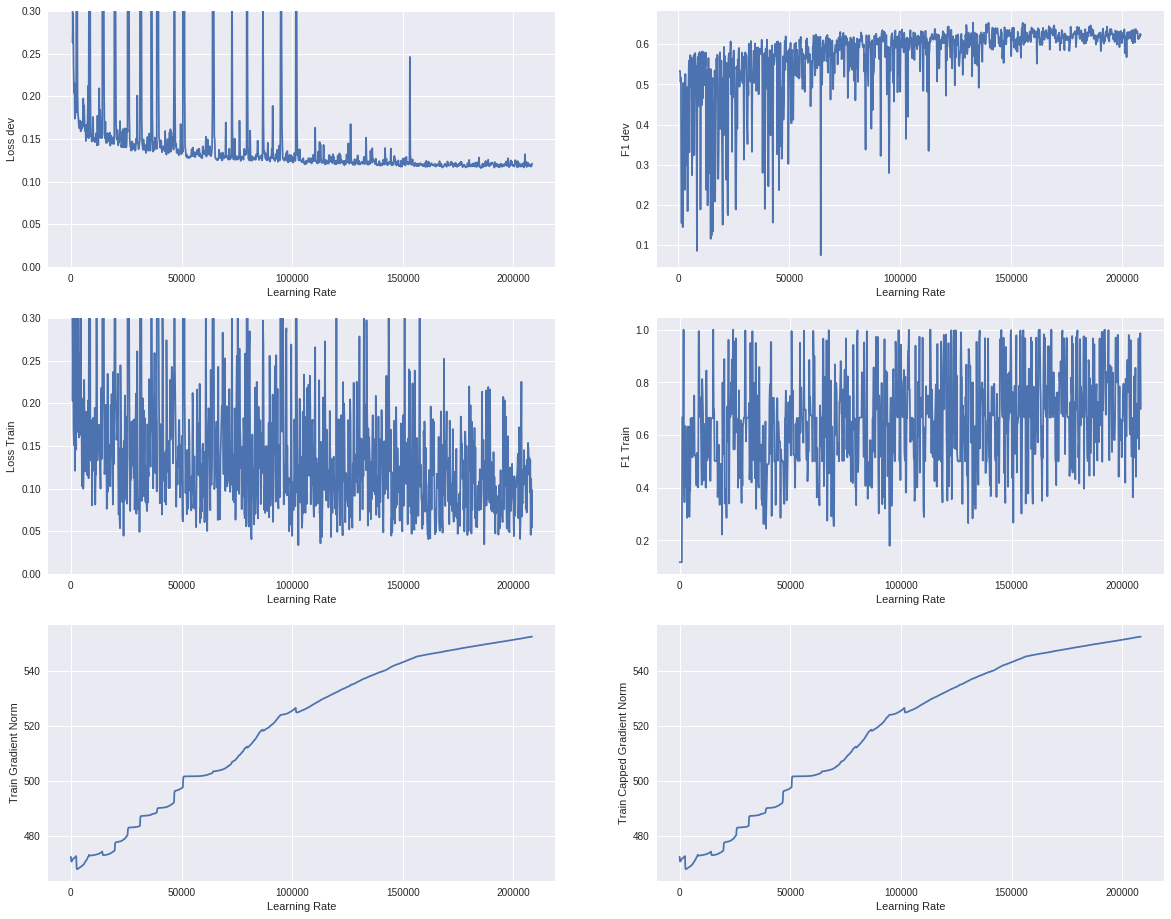

In [17]:
alpha = 0.1
ewma_loss_dev = numpy_ewma_vectorized(loss_stack, alpha)
ewma_f1_dev = numpy_ewma_vectorized(f1_stack, alpha)
ewma_loss_train = numpy_ewma_vectorized(loss_train_stack, alpha)
ewma_f1_train = numpy_ewma_vectorized(f1_train_stack, alpha)
ewma_grads_l2_norm = numpy_ewma_vectorized(grads_train_stack, alpha)
ewma_capped_grads_l2_norm = numpy_ewma_vectorized(capped_grads_train_stack, alpha)

plt.figure(figsize = (20, 16))
plt.subplot(321) 
plt.plot(step_stack, ewma_loss_dev)
plt.xlabel("Learning Rate")
plt.ylabel("Loss dev")
plt.ylim([0,.3])
plt.subplot(322)
plt.plot(step_stack, ewma_f1_dev)
plt.xlabel("Learning Rate")
plt.ylabel("F1 dev")

plt.subplot(323) 
plt.plot(step_stack, ewma_loss_train)
plt.xlabel("Learning Rate")
plt.ylabel("Loss Train")
plt.ylim([0,0.3])
plt.subplot(324)
plt.plot(step_stack, ewma_f1_train)
plt.xlabel("Learning Rate")
plt.ylabel("F1 Train")

plt.subplot(325)
plt.plot(step_stack,ewma_grads_l2_norm)
plt.xlabel("Learning Rate")
plt.ylabel("Train Gradient Norm")

plt.subplot(326)
plt.plot(step_stack,ewma_capped_grads_l2_norm)
plt.xlabel("Learning Rate")
plt.ylabel("Train Capped Gradient Norm")

plt.show()

In [16]:
MODELS_FILE = "models/model{}/QIQC_model{}.ckpt".format(model_version,model_version)
modfil = os.path.join(DRIVE_PATH,MODELS_FILE)
X_cv_lengths, X_cv_set, y_cv_set = QIQC.cross_val_set()

with tf.Session() as sess: 
    saver.restore(sess, modfil)
    f1_cv = f1.eval(feed_dict = {X : X_cv_set, y : y_cv_set})
    f1_dev = f1.eval(feed_dict = {X : X_dev_set, y : y_dev_set})

f1_cv_pc = f1_cv * 100
f1_dev_pc = f1_dev * 100
print("cross val f1 {:.2f}%, dev f1 {:.2f}%".format(f1_cv_pc, f1_dev_pc))

INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/Colab Notebooks/models/model4.2/QIQC_model4.2.ckpt
cross val f1 47.83%, dev f1 64.39%
